In [ ]:
!conda config --add channels conda-forge
!conda install -y --update-dependencies fenics mshr matplotlib

rve
press
pressTop
block
coarse
sparse


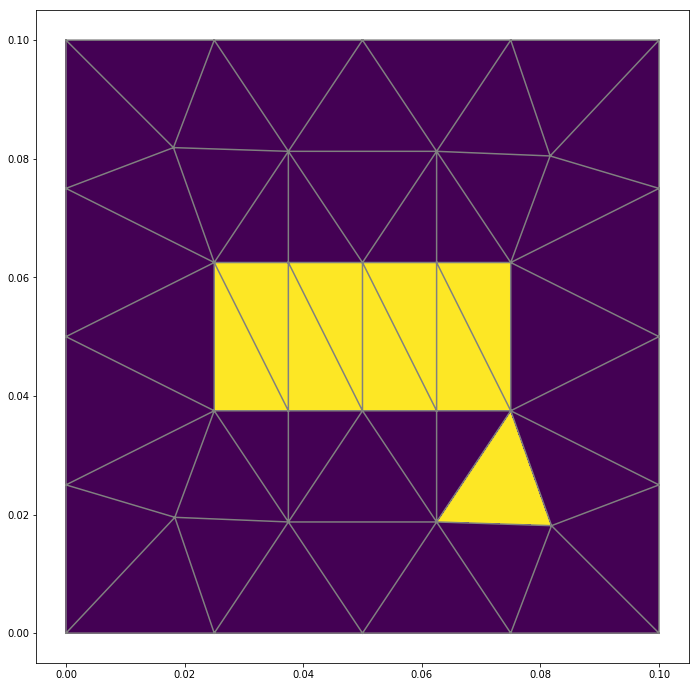

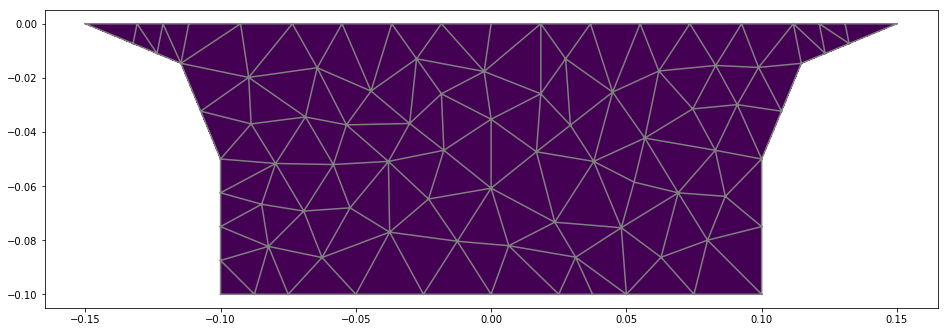

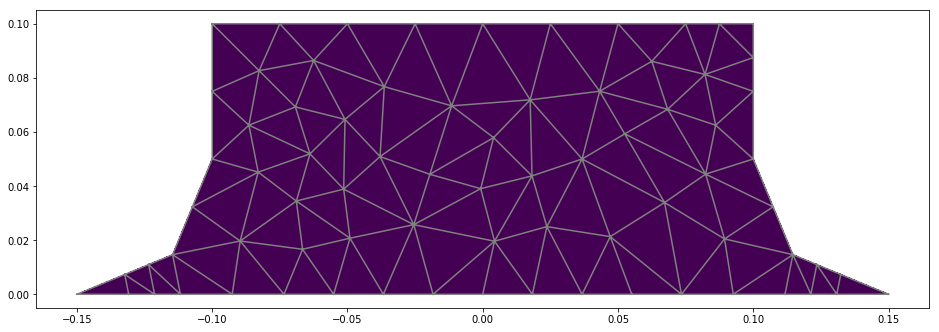

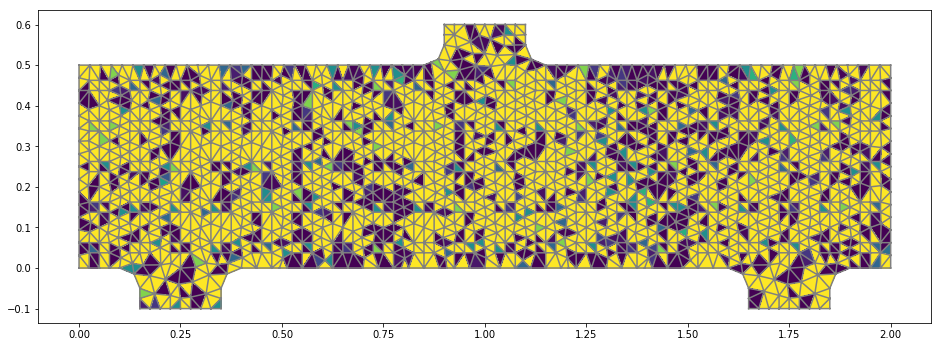

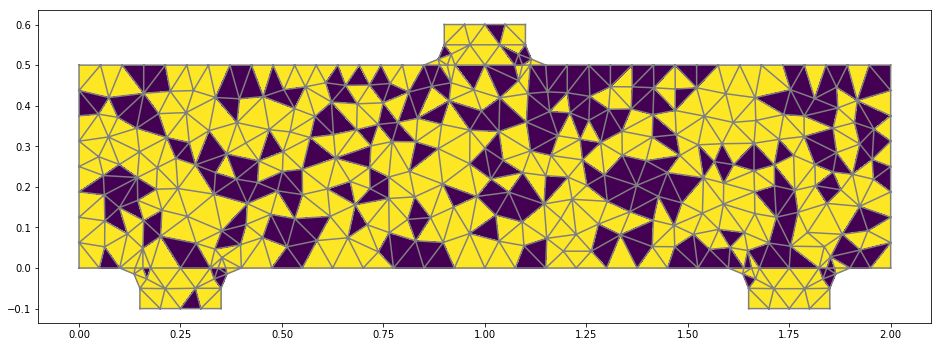

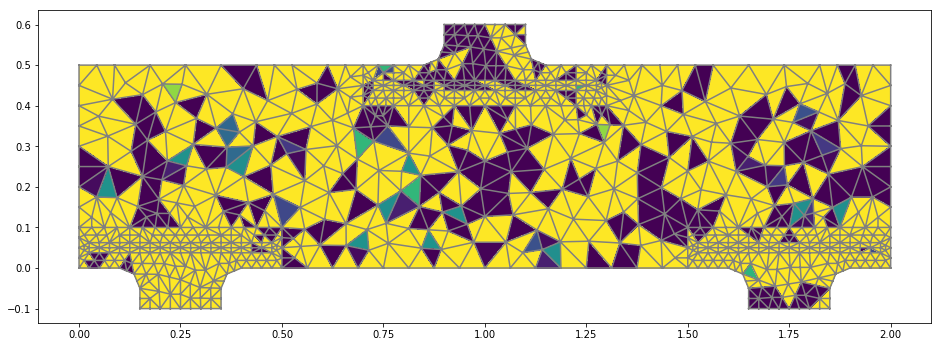

In [4]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
import math

def Fiber(w, h, x, y):
    domain = Rectangle(Point(x - w/2, y - h/2), Point(x + w/2, y + h/2))
    return domain

def Composite(w, h, fw, fh, dx, dy, add=None):
    domain = Rectangle(Point(0, 0), Point(w, h))
    if not add is None:
        domain += add
    nx = int(w / dx)
    ny = int(h / dy)
    for i in range(nx):
        x = w * (i + 0.5) / nx 
        for j in range(ny):
            y = h * (j + 0.5) / ny
            domain.set_subdomain(i * ny + j + 1, Fiber(fw, fh, x, y))
    return domain

def Press(w, h, rx, ry, s):
    domain = Rectangle(Point(-w/2, -h), Point(w/2, 0)) \
           - Ellipse(Point(-w/2, -ry), rx, ry, s) \
           - Ellipse(Point(w/2, -ry), rx, ry, s) \
           - Rectangle(Point(-w/2, -h), Point(-w/2 + rx, -ry)) \
           - Rectangle(Point(w/2 - rx, -h), Point(w/2, -ry))
    return domain

def PressTop(w, h, rx, ry, s):
    domain = Rectangle(Point(-w/2, 0), Point(w/2, h)) \
           - Ellipse(Point(-w/2, ry), rx, ry, s) \
           - Ellipse(Point(w/2, ry), rx, ry, s) \
           - Rectangle(Point(-w/2, ry), Point(-w/2 + rx, h)) \
           - Rectangle(Point(w/2 - rx, ry), Point(w/2, h))
    return domain

def Block(w, h, fw, fh, dx, dy, p, pt, sw):
    presses = CSGTranslation(p, Point(sw/2, 0)) \
            + CSGTranslation(p, Point(w-sw/2, 0)) \
            + CSGTranslation(pt, Point(w/2, h))
    domain = Composite(w, h, fw, fh, dx, dy, presses)
    return domain

def CoarseBlock(w, h, p, pt, sw):
    presses = CSGTranslation(p, Point(sw/2, 0)) \
            + CSGTranslation(p, Point(w-sw/2, 0)) \
            + CSGTranslation(pt, Point(w/2, h))
    domain = Rectangle(Point(0, 0), Point(w, h)) + presses
    domain.set_subdomain(1, presses)
    return domain

def SparseBlock(w, h, fw, fh, dx, dy, p, pt, sw, swt, sh):
    p = p + Rectangle(Point(-sw/2, 0), Point(sw/2, sh))
    pt = pt + Rectangle(Point(-swt/2, -sh), Point(swt/2, 0))
    presses = CSGTranslation(p, Point(sw/2, 0)) \
            + CSGTranslation(p, Point(w-sw/2, 0)) \
            + CSGTranslation(pt, Point(w/2, h))
    domain = Rectangle(Point(0, 0), Point(w, h)) + presses
    domain.set_subdomain(1, presses)
    nx = int(w / dx)
    ny = int(h / dy)
    for i in range(nx):
        x = w * (i + 0.5) / nx
        for j in range(ny):
            y = h * (j + 0.5) / ny
            if near(x, sw/2, sw/2) and near(y, 0, sh) \
            or near(x, w-sw/2, sw/2) and near(y, 0, sh) \
            or near(x, w/2, sw/2) and near(y, h, sh):
                domain.set_subdomain(i * ny + j + 2, Fiber(fw, fh, x, y))
    return domain

def save(geo, name, resolution, refineTimes=0):
    print(name)
    mesh = generate_mesh(geo, resolution)
    domains = MeshFunction("size_t", mesh, 2, mesh.domains())
    for r in range(refineTimes):
        need_refine = MeshFunction("bool", mesh, 2, False)
        for c in cells(mesh):
            if domains[c] > 0:
                need_refine[c] = True
        mesh = refine(mesh, need_refine)
        domains = adapt(domains, mesh)
    File("meshes/" + name + ".xml") << mesh
    File("meshes/" + name + "_domains.xml") << domains
    File("meshes/" + name + "_domains.pvd") << domains
    plt.figure(figsize=(16, 12))
    plot(mesh)
    plot(domains)
    

fiberWidth  = 0.05
fiberHeight = 0.025
densityX    = 0.1
densityY    = 0.1
rveWidth    = 0.1
rveHeight   = 0.1
blockWidth  = 2.0
blockHeight = 0.5
pressWidth  = 0.3
pressHeight = 0.1
roundX      = 0.05
roundY      = 0.05
resolution  = 40
coarse      = 20
segments    = 8
refineTimes = 1
sparseWidth = 5*rveWidth
sparseTop   = 6*rveWidth


rve = Composite(rveWidth, rveHeight, fiberWidth, fiberHeight, densityX, densityY)
save(rve, "rve", sqrt(rveWidth*rveHeight)*resolution)

press = Press(pressWidth, pressHeight, roundX, roundY, segments)
save(press, "press", sqrt(pressWidth*pressHeight)*resolution)

pressTop = PressTop(pressWidth, pressHeight, roundX, roundY, segments)
save(pressTop, "pressTop", sqrt(pressWidth*pressHeight)*resolution)

block = Block(blockWidth, blockHeight, fiberWidth, fiberHeight, densityX, densityY, press, pressTop, sparseWidth)
save(block, "block", sqrt(blockWidth*blockHeight)*resolution)

block = CoarseBlock(blockWidth, blockHeight, press, pressTop, sparseWidth)
save(block, "coarse", sqrt(blockWidth*blockHeight)*coarse)

block = SparseBlock(blockWidth, blockHeight, fiberWidth, fiberHeight, densityX, densityY, press, pressTop, sparseWidth, sparseTop, rveHeight)
save(block, "sparse", sqrt(blockWidth*blockHeight)*coarse, refineTimes)

plt.show()